In [1]:
transit_edges = sqlContext.read.parquet("/FileStore/tables/gtfs/nyc/NYC_Subway_Edges.parquet")
nyc_roads = sqlContext.read.parquet("/FileStore/tables/Roads/NYC/NYC_Road_edges.parquet")
#sameG = GraphFrame(sameV, sameE)

In [2]:
!pip install networkx
!pip install descartes
!pip install shapely
!pip install geopandas

In [3]:
import networkx as nx
from scipy.spatial import Delaunay
from shapely.ops import cascaded_union, polygonize
from shapely.geometry import MultiPoint, Polygon, MultiLineString, MultiPolygon, Point
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from pyspark.sql.types import *
from pyspark.sql.functions import lit, col, min
from math import radians, cos, sin, asin, sqrt, atan2, pi
import pandas as pd
import time

In [4]:
display(transit_edges)

src,dst,src_stop_id,dst_stop_id,src_lon,src_lat,dst_lon,dst_lat,time_cost,modal_station
131S-1-South Ferry-MTA NYCT,131N-1-Van Cortlandt Park - 242 St-MTA NYCT,131S,131N,-73.997871,40.74104,-73.997871,40.74104,431.42857142857144,false
242S-2-Flatbush Av - Brooklyn College-MTA NYCT,242N-2-Wakefield - 241 St-MTA NYCT,242S,242N,-73.95085,40.662742,-73.95085,40.662742,606.0,false
242S-2-Flatbush Av - Brooklyn College-MTA NYCT,242N-5-Nereid Av-MTA NYCT,242S,242N,-73.95085,40.662742,-73.95085,40.662742,1175.0,false
242S-2-Flatbush Av - Brooklyn College-MTA NYCT,242N-5X-Eastchester - Dyre Av-MTA NYCT,242S,242N,-73.95085,40.662742,-73.95085,40.662742,822.0,false
242S-5-Flatbush Av - Brooklyn College-MTA NYCT,242N-2-Wakefield - 241 St-MTA NYCT,242S,242N,-73.95085,40.662742,-73.95085,40.662742,606.0,false
242S-5-Flatbush Av - Brooklyn College-MTA NYCT,242N-5-Nereid Av-MTA NYCT,242S,242N,-73.95085,40.662742,-73.95085,40.662742,1175.0,false
242S-5-Flatbush Av - Brooklyn College-MTA NYCT,242N-5X-Eastchester - Dyre Av-MTA NYCT,242S,242N,-73.95085,40.662742,-73.95085,40.662742,822.0,false
242N-2-Wakefield - 241 St-MTA NYCT,242N-5-Nereid Av-MTA NYCT,242N,242N,-73.95085,40.662742,-73.95085,40.662742,995.0,false
242N-2-Wakefield - 241 St-MTA NYCT,242N-5X-Eastchester - Dyre Av-MTA NYCT,242N,242N,-73.95085,40.662742,-73.95085,40.662742,642.0,false
242N-5-Nereid Av-MTA NYCT,242N-2-Wakefield - 241 St-MTA NYCT,242N,242N,-73.95085,40.662742,-73.95085,40.662742,426.0,false


In [5]:
display(nyc_roads)

osm_id,fclass,name,ref,oneway,maxspeed,segment,dist,src_coord,dst_coord,imp_fclass,time_in_s,walk_time,src,dst
222788006,secondary,Amboy Road,null,B,0,"List(List(-74.2522428, 40.5075915), List(-74.252878, 40.507625))",53.891183774827496,"List(-74.2522428, 40.5075915)","List(-74.252878, 40.507625)",null,2.1923076059594213,62.583310190122255,18,14
5711061,residential,Saint Andrews Place,null,B,0,"List(List(-74.2388444, 40.517557), List(-74.2390753, 40.5175083))",20.27810110876653,"List(-74.2388444, 40.517557)","List(-74.2390753, 40.5175083)",null,1.814820733164935,23.548762577922425,240,225
68665400,tertiary,Richmond Valley Road,null,B,0,"List(List(-74.235112, 40.520917), List(-74.23392, 40.520703))",103.64342318468894,"List(-74.235112, 40.520917)","List(-74.23392, 40.520703)",traffic_signals,21.46624186072524,120.36010434350973,325,351
5713584,residential,Peacock Loop,null,B,0,"List(List(-74.2212935, 40.5304503), List(-74.221213, 40.5308334))",43.186716427129625,"List(-74.2212935, 40.5304503)","List(-74.221213, 40.5308334)",null,3.865063496275119,50.15231585086021,567,568
430414006,residential,Seguine Avenue,null,B,0,"List(List(-74.1968778, 40.5131272), List(-74.1969199, 40.5130064))",13.911328044487659,"List(-74.1968778, 40.5131272)","List(-74.1969199, 40.5130064)",null,1.2450163072754648,16.155090632308248,1403,1398
222788216,tertiary,Woodrow Road,null,B,0,"List(List(-74.191527, 40.546908), List(-74.191896, 40.546672), List(-74.192268, 40.546433))",82.00444322105142,"List(-74.191527, 40.546908)","List(-74.192268, 40.546433)",null,3.3359624339881924,95.230966321221,1640,1598
574785928,residential,Jansen Street,null,B,0,"List(List(-74.1871801, 40.5255457), List(-74.1876553, 40.5253684), List(-74.1885499, 40.5250429), List(-74.188721, 40.524983))",144.65407032793934,"List(-74.1871801, 40.5255457)","List(-74.188721, 40.524983)",null,12.946044827360637,167.985371993736,1844,1757
5710960,tertiary_link,null,null,F,0,"List(List(-74.1794099, 40.6083601), List(-74.1794501, 40.6083234), List(-74.1794794, 40.6082622), List(-74.1794818, 40.6081805), List(-74.1794297, 40.6080779), List(-74.1793493, 40.6079895), List(-74.1792433, 40.6078612))",62.71741112947846,"List(-74.1792433, 40.6078612)","List(-74.1794099, 40.6083601)",null,5.612993910904224,72.83312260197498,2187,2181
5711556,residential,Berry Avenue West,null,F,0,"List(List(-74.179352, 40.56008), List(-74.177982, 40.560239))",117.20717549284866,"List(-74.177982, 40.560239)","List(-74.179352, 40.56008)",null,10.489641560578129,136.11155863685653,2265,2182
5712221,residential,Sunfield Avenue,null,F,0,"List(List(-74.177982, 40.560239), List(-74.177834, 40.559565))",76.06577622001224,"List(-74.177834, 40.559565)","List(-74.177982, 40.560239)",null,6.8076269581614435,88.33444980388518,2273,2265


In [6]:
transit_modal_stn_srch_bounds = transit_edges.where("modal_station = true")
transit_modal_stn_srch_bounds = transit_modal_stn_srch_bounds.withColumn("bounds", get_bounds_udf(transit_modal_stn_srch_bounds.dst_lon, transit_modal_stn_srch_bounds.dst_lat, lit(900), lit('walk')))
transit_modal_stn_srch_bounds = (transit_modal_stn_srch_bounds
                                 .withColumn("min_lon", transit_modal_stn_srch_bounds.bounds[0])
                                 .withColumn("min_lat", transit_modal_stn_srch_bounds.bounds[1])
                                 .withColumn("max_lon", transit_modal_stn_srch_bounds.bounds[2])
                                 .withColumn("max_lat", transit_modal_stn_srch_bounds.bounds[3])
                                )

In [7]:
display(transit_modal_stn_srch_bounds)

src,dst,src_stop_id,dst_stop_id,src_lon,src_lat,dst_lon,dst_lat,time_cost,modal_station,bounds,min_lon,min_lat,max_lon,max_lat
F06,F06N-F-Jamaica - 179 St-MTA NYCT,F06,F06,-73.831008,40.714441,-73.831008,40.714441,453.2432432432432,true,"List(-73.84583, 40.703197, -73.81618, 40.72568)",-73.84583,40.703197,-73.81618,40.72568
B14,B14N-D-Norwood - 205 St-MTA NYCT,B14,B14,-73.994791,40.63626,-73.994791,40.63626,728.3333333333334,true,"List(-74.009605, 40.62502, -73.97997, 40.6475)",-74.009605,40.62502,-73.97997,40.6475
132,132N-1-Van Cortlandt Park - 242 St-MTA NYCT,132,132,-74.000201,40.737826,-74.000201,40.737826,431.42857142857144,true,"List(-74.01504, 40.726585, -73.98536, 40.749065)",-74.01504,40.726585,-73.98536,40.749065
612,612S-6-Brooklyn Bridge - City Hall-MTA NYCT,612,612,-73.886283,40.826525,-73.886283,40.826525,418.7234042553191,true,"List(-73.90114, 40.81528, -73.87142, 40.837765)",-73.90114,40.81528,-73.87142,40.837765
F06,F06S-F-Coney Island - Stillwell Av-MTA NYCT,F06,F06,-73.831008,40.714441,-73.831008,40.714441,654.2857142857142,true,"List(-73.84583, 40.703197, -73.81618, 40.72568)",-73.84583,40.703197,-73.81618,40.72568
B08,B08S-F-Coney Island - Stillwell Av-MTA NYCT,B08,B08,-73.966113,40.764629,-73.966113,40.764629,655.7142857142858,true,"List(-73.98095, 40.753387, -73.95127, 40.77587)",-73.98095,40.753387,-73.95127,40.77587
M11,M11N-M-Forest Hills - 71 Av-MTA NYCT,M11,M11,-73.935657,40.697207,-73.935657,40.697207,675.0,true,"List(-73.950485, 40.685963, -73.92083, 40.708447)",-73.950485,40.685963,-73.92083,40.708447
R30,R30S-R-Bay Ridge - 95 St-MTA NYCT,R30,R30,-73.981824,40.690635,-73.981824,40.690635,607.5,true,"List(-73.99665, 40.679394, -73.966995, 40.701874)",-73.99665,40.679394,-73.966995,40.701874
420,420N-4-Burnside Av-MTA NYCT,420,420,-74.014065,40.704817,-74.014065,40.704817,2070.0,true,"List(-74.02889, 40.693573, -73.99924, 40.716057)",-74.02889,40.693573,-73.99924,40.716057
B10,B10S-F-Kings Hwy-MTA NYCT,B10,B10,-73.97745,40.763972,-73.97745,40.763972,987.6923076923077,true,"List(-73.99229, 40.75273, -73.96261, 40.77521)",-73.99229,40.75273,-73.96261,40.77521


In [8]:

@udf('float')
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6378100 # Radius of earth in meters. Use 3956 for miles
    return float(c * r)

In [9]:
new_edges = (nyc_roads.alias("a")
             .join(transit_modal_stn_srch_bounds.alias("b"), 
                   (col("a.dst_lon") > col("b.min_lon")) 
                   & (col("a.dst_lat") > col("b.min_lat")) 
                   & (col("a.dst_lon") < col("b.max_lon"))
                   & (col("a.dst_lat") < col("b.max_lat"))
                  )
             .select([
               col("a.dst").alias("src"), 
               col("b.src").alias("dst"),
               haversine(col("a.dst_lon"), col("a.dst_lat"), col("b.src_lon"), col("b.src_lat")).alias("dist"),
               col("a.dst_lon").alias("src_lon"),
               col("a.dst_lat").alias("src_lat"),
               col("b.src_lon").alias("dst_lon"),
               col("b.src_lat").alias("dst_lat")
             ])
            )

new_edges = new_edges.withColumn("time_cost", new_edges.dist * 18/25)
display(new_edges)

src,dst,dist,src_lon,src_lat,dst_lon,dst_lat,time_cost
14,S11,1351.2777,-74.252878,40.507625,-74.242096,40.516578,972.919921875
14,S09,577.30804,-74.252878,40.507625,-74.251961,40.512764,415.661796875
225,S11,275.81015,-74.2390753,40.5175083,-74.242096,40.516578,198.58330078125
225,S09,1211.6532,-74.2390753,40.5175083,-74.251961,40.512764,872.3903125
225,S13,873.2586,-74.2390753,40.5175083,-74.229141,40.519631,628.7462109375
351,S11,830.39844,-74.23392,40.520703,-74.242096,40.516578,597.886875
351,S13,421.64804,-74.23392,40.520703,-74.229141,40.519631,303.58658203125
568,S14,979.98303,-74.221213,40.5308334,-74.217847,40.52241,705.5878125
568,S14,979.98303,-74.221213,40.5308334,-74.217847,40.52241,705.5878125
568,S13,1416.0231,-74.221213,40.5308334,-74.229141,40.519631,1019.536640625


In [10]:
new_edges_min_time = (new_edges
         .groupby(["dst"])
         .agg(min("time_cost").alias("min_time"))
                )

new_edges = (new_edges.alias("a")
             .join(new_edges_min_time.alias("b"), (col("a.dst") == col("b.dst")) & (col("a.time_cost") == col("b.min_time")))
             .select([col("a.src"), col("a.dst"), col("a.src_lon"), col("a.src_lat"), col("a.dst_lon"), col("a.dst_lat"), col("a.time_cost")])
             .distinct()
            )

new_edges = new_edges.unionAll(new_edges.select([col("dst").alias("src"), col("src").alias("dst"), col("a.src_lon").alias("dst_lon"), col("a.src_lat").alias("dst_lat"), col("a.dst_lon").alias("src_lon"), col("a.dst_lat").alias("dst_lat"), col("time_cost")]))

display(new_edges)

src,dst,src_lon,src_lat,dst_lon,dst_lat,time_cost
18459,B13,-73.99431,40.640914,-73.994304,40.640914,0.36490806579589846
18679,129,-73.9933621,40.7472363,-73.993365,40.747215,1.7162432861328125
17289,B20,-73.998254,40.604608,-73.998168,40.604556,6.6900439453125
16339,A31,-74.001555,40.74108,-74.00169,40.740893,17.083565673828126
14027,228,-74.0092662,40.7132584,-74.008811,40.713051,32.26591552734375
17111,B17,-73.998812,40.619721,-73.998864,40.619589,11.04259765625
20045,F23,-73.9893424,40.6706512,-73.989779,40.670272,40.3504931640625
24948,D42,-73.9765001,40.5766549,-73.975939,40.576127,54.37814453125
11630,R45,-74.030845,40.616699,-74.030876,40.616622,6.4532763671875
B13,18459,-73.99431,40.640914,-73.994304,40.640914,0.36490806579589846


In [11]:
walk_transit_edges = (nyc_roads.select([col("src"), col("dst"), col("src_lon"), col("src_lat"), col("dst_lon"), col("dst_lat"), col("walk_time").alias("time_cost")])
                      .union(transit_edges.select([col("src"), col("dst"),  col("src_lon"), col("src_lat"), col("dst_lon"), col("dst_lat"), col("time_cost")]))
                      .union(new_edges)
                     )

In [12]:
def generate_alpha_poly(coords, alpha):
    start = time.time()
    if len(coords) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(coords).convex_hull
    edges = set()
    edge_points = []
    def add_edge(i, j):
      """
      if (i, j) in edges or (j, i) in edges:
        return
      edges.add( (i, j) )
      """
      edge_points.append(coords[ [i, j] ])
      
    # Compute Delauney traingles
    tri = Delaunay(coords)
    
    # loop over triangles:
    # ia, ib, ic = indices of the points forming the simplices in the triangulation. 
   
    for ia, ib, ic in tri.simplices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        # Lengths of sides of triangle
        try:
          a = sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
          b = sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
          c = sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
          # Semiperimeter of triangle
          s = (a + b + c)/2.0
          # Area of triangle by Heron's formula
          area = sqrt(s*(s-a)*(s-b)*(s-c))
          circum_r = a*b*c/(4.0*area)
          # Here's the radius filter.
          if circum_r < 1.0/alpha:
              add_edge(ia, ib)
              add_edge(ib, ic)
              add_edge(ic, ia)
        except ValueError: 
          #print("Value Error encountered\ns : {}, a : {}, b : {}, c: {}".format(s, a, b, c))
          continue
        except ZeroDivisionError: 
          #print("Zero Division error encountered")
          continue
    b = np.array(edge_points)
    u, counts = np.unique(b, axis = 0, return_counts =True)
    u = u[counts == 1]

    m = MultiLineString(list(u))
    triangles = list(polygonize(m))
    alpha_poly = cascaded_union(triangles)
    return alpha_poly
  
  
def CalculateLocationTimeMatrix(pyspark_edge_df, src_node_id, weight_value, weight_field= "time_cost"):
  """Calculates Location Time Matrix
  
  Returns a pandas dataframe with the following columns: dst_lat, dst_lon, time 
  The time column is in minutes
  
  Args:
  
    pyspark_edge_df : pyspark dataframe of the edge with given bounds
    src_node_id : node id of the source 
    weight_value : can either be in seconds or in meters
    weight_field : the field in pyspark edge dataframe which acts as weight for the graph
    alpha : Used for triangulation of points. The higher the value, finer triangles are formeed (Default is 150)
  
  Returns:
    loc_time_matrix_agg: pandas dataframe
  """
  pd_edge_df = pyspark_edge_df.toPandas()

  agg_loc_coeff = 3
    
  G = nx.from_pandas_edgelist (df = pd_edge_df, source  = "src", target = "dst", \
                             edge_attr  = [weight_field], \
                             create_using  = nx.DiGraph())
  
  spl = nx.single_source_dijkstra_path_length(G, source=src_node_id, cutoff = weight_value, weight=weight_field)
  spl_df = pd.DataFrame(spl.items(), columns=['id', 'time'])
  merged = pd.merge(pd_edge_df, spl_df, left_on='dst', right_on="id", how='inner')
  
  loc_time_matrix = merged[["dst_lat", "dst_lon", "time"]]
  loc_time_matrix_agg = loc_time_matrix.round(agg_loc_coeff).groupby(["dst_lat", "dst_lon"])[['time']].mean()
  loc_time_matrix_agg["time"] = loc_time_matrix_agg["time"]//60
  loc_time_matrix_agg.reset_index(level=["dst_lon", "dst_lat"], inplace = True)
  
  return loc_time_matrix_agg 
         
def return_isochrone(df, time_threshold = 30, alpha = 150):
  """
  Args:
    df: pandas dataframe. Location Time Matrix dataframe for the source node created in the previous step
    time_threshold : time in minutes for which isochrone is needed
    alpha : Used for triangulation of points. The higher the value, finer triangles are formeed (Default is 150)
  
  Returns:
    alpha_poly: shapely.geometry.Polygon representing the isochrone
  """
  
  df = df[df["time"] <= time_threshold]
  pts = df[["dst_lon", "dst_lat"]].as_matrix()
  alpha_poly =  generate_alpha_poly(pts, alpha = alpha)
  return alpha_poly

In [13]:
@udf(ArrayType(FloatType()))
def get_bounds_udf(lon_d, lat_d, time_in_s, mode='drive'):
  return get_bounds(lon_d, lat_d, time_in_s, mode)
  
  
def calc_bounds(lon_d, lat_d, d):
  """
    * For a given lat-long and distance in kilometers, this function provides the bounds of polygon which is d kilometers away from the centroid in the four cardinal directions

    * This is needed to select a subgraph for our analysis

    * The value of d is based on the time selected and mode of commute. 

      * e.g., for a 30 minute drive time, assumping a max speed of 105 kmph along road, the max, one can travel is 52.5 kms in any direction from the center, so d should be 52.5
      * For 10 mins walk at 5 kmph, d value should be ~ 0.84
  
  """
  RADIUS_OF_EARTH = 6371.0088
  d = d * sqrt(2)
  poly = []
  for a in range(45, 360, 180): # Bearings of the diagonally opposite bearings 45, 225 (NE, SW)
    
    # Convert the bearing and lat long into radians
    bearing = pi / 180.0 * a    
    lat = pi * lat_d / 180.0
    lon = pi * lon_d / 180.0
    
    new_lat = asin(sin(lat) * cos(d/RADIUS_OF_EARTH) + cos(lat) * sin(d/RADIUS_OF_EARTH) * cos(bearing))
    new_lon = lon + atan2(sin(bearing) * sin(d/RADIUS_OF_EARTH) * cos(lat) ,cos(d/RADIUS_OF_EARTH) - sin(lat) * sin(new_lat))
    new_lat *= 180.0/pi
    new_lon *= 180.0/pi
    
    poly.append([new_lon, new_lat])
  bounds = list(np.min(np.array(poly), axis = 0))
  bounds.extend(list(np.max(np.array(poly), axis = 0)))
  bounds = [float(item) for item in bounds]
  return bounds


def get_bounds(lon_d, lat_d, time_in_s, mode='drive'):
  """
  mode = {'drive', 'walk', 'transit'}
  """
  MAX_SPEED_IN_US_KMPH = 128.0
  SPEED_OF_WALK_KMPH = 5.0
  MAX_SPEED_NYC_SUBWAY = 52.0
  
  if mode == 'walk':
    d = SPEED_OF_WALK_KMPH * time_in_s / 3600.0
  elif mode == "transit":
    d = MAX_SPEED_NYC_SUBWAY * time_in_s / 3600.0
  else:
    d = MAX_SPEED_IN_US_KMPH * time_in_s / 3600.0
  bounds = calc_bounds(lon_d, lat_d, d)
  return bounds

bounds = get_bounds(-122.4119388,37.741981, 1800, "transit")
bounds

Out[ 96 ]: 
[-122.70669703107325,
 37.50779019978661,
 -122.11531244252701,
 37.975433157548714]

In [14]:
walk_transit_edges.count()

In [15]:
def extract_edges(lon, lat, time, mode="transit"): 
  bounds = get_bounds(lon, lat, time, mode)
  e2 = walk_transit_edges.filter("src_lon > {} and src_lat > {} and src_lon <  {} and src_lat < {}".format(bounds[0], bounds[1], bounds[2], bounds[3]))
  return e2

In [16]:
def closest_node(node, nodes):
    #nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)


In [17]:
"""
Test. Comment out

nodes = np.random.normal([-73.5,40],[0.5, 0.5], (380000,2))
node = [-73.980779,	40.644254]
ind = closest_node(node, nodes)
nodes[ind]
"""

Out[ 99 ]: '\nTest. Comment out\n\nnodes = np.random.normal([-73.5,40],[0.5, 0.5], (380000,2))\nnode = [-73.980779,\t40.644254]\nind = closest_node(node, nodes)\nnodes[ind]\n'

In [18]:
nodes_with_ids = (np.array(transit_edges.where("modal_station = true")
                           .select(["src", "src_lon", "src_lat"])
                           .union(nyc_roads.select(["src", "src_lon", "src_lat"]))
                           .collect()
                          )
                 )

nodes = nodes_with_ids[:,[1,2]].astype(np.float)
ids = nodes_with_ids[:,[0]]

In [19]:
node = [-74.011377, 40.706868] # New York Stock Exchange
ind = closest_node(node, nodes)
ids[ind][0]

Out[ 101 ]: u'13589'

In [20]:
e = extract_edges(node[0], node[1], 1800)
location_time_matrix  = CalculateLocationTimeMatrix(e, ids[ind][0], 1800)

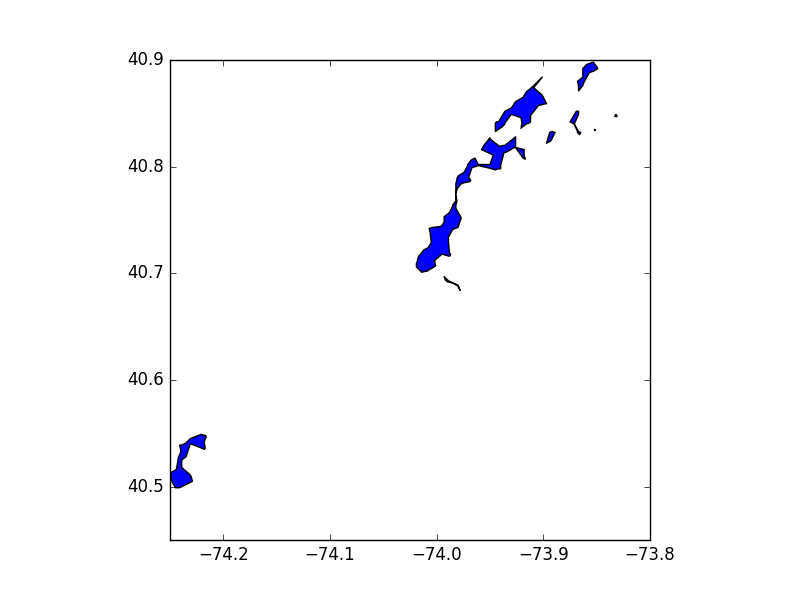

In [21]:
poly = return_isochrone(location_time_matrix, 30)
polygon_coords = [list(geom.exterior.coords) for geom in poly.geoms]
spd = gpd.GeoDataFrame({"geometry" : gpd.GeoSeries(poly)})
f = spd.plot()
display(f.figure)

In [22]:
location_time_matrix.to_csv("/dbfs/FileStore/loc_time_matrix_agg.csv")


<h4> Access ^^ above file at this <a href="https://community.cloud.databricks.com/files/loc_time_matrix_agg.csv"/>url</h4>